This notebook analyzes the dataset from https://www.lendingclub.com/
------------------------------------------------------------------------------------------------------





Objectives:
The goal is to analyse the following:

    The target variable
    Variable types (categorical and numerical)
    Missing data

    Numerical variables
        Discrete
        Continuous
        Distributions
        Transformations

    Categorical variables
        Cardinality
        Special Labels

## Import the necessary libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer
import category_encoders as ce
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy import stats
import scipy
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier
import torch
import torchvision
import torchvision.transforms as transforms
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import StratifiedKFold

## Read the data

In [2]:
data = pd.read_csv("https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Lending_Club.csv")
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns="is_bad"), data["is_bad"], test_size=0.20, random_state=42)

In [3]:
data.sample(5)

,Id,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
2339,2340,0,MW Builders,10,MORTGAGE,90000.0,VERIFIED - income source,n,NaN,medical,...,NaN,7.0,0.0,195,8.9,21.0,f,0.0,3,PC1
6696,6697,1,"The Ultimate Software Group, Inc",8,MORTGAGE,119000.0,VERIFIED - income source,n,NaN,debt consolidation,...,NaN,10.0,0.0,31881,98.7,23.0,f,0.0,3,PC5
9242,9243,0,Tuscany Eyewear,10,RENT,84000.0,not verified,n,NaN,other,...,NaN,9.0,0.0,3001,31.9,21.0,f,0.0,3,PC1
6438,6439,0,Rosenbauer General Safety,2,RENT,37000.0,VERIFIED - income source,n,Borrower added on 04/22/10 > My current car ...,car,...,NaN,7.0,0.0,10143,41.3,16.0,f,0.0,1,PC3
9212,9213,0,Sweetwater Fire Department,10,MORTGAGE,58000.0,VERIFIED - income source,n,NaN,debt consolidation,...,NaN,10.0,0.0,14893,44.2,28.0,f,0.0,3,PC3


In [4]:
data.shape

(10000, 28)

In [5]:
original_features = list(data.columns)
print(original_features)

['Id', 'is_bad', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'Notes', 'purpose_cat', 'purpose', 'zip_code', 'addr_state', 'debt_to_income', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code']


## Explore the target feature

In [6]:
target = data['is_bad']

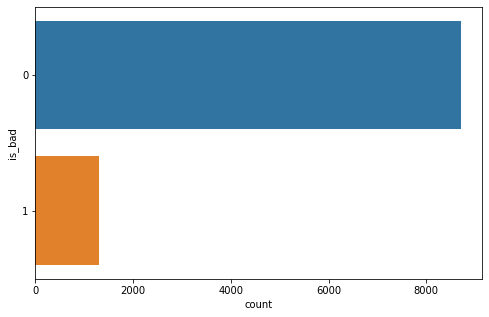

In [7]:
plt.figure(figsize=(8,5));
sns.countplot(y=target);

The dataset is very imbalance. We will process a combination of oversampling or undersampling

## Split Variable types (categorical and numerical)

In [8]:
cat_vars = [var for var in data.columns if(data[var].dtypes == "O")]
print(cat_vars)
print()
print(f"length of categorical variable is {len(cat_vars)}")

['emp_title', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'Notes', 'purpose_cat', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'policy_code']

length of categorical variable is 13


In [9]:
num_vars = [var for var in data.columns if(var not in cat_vars)]
print(num_vars)
print()
print(f"lenght of numerical variables is {len(num_vars)}")

['Id', 'is_bad', 'annual_inc', 'debt_to_income', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog']

lenght of numerical variables is 15


## Explore missing data

In [10]:
missing_data = pd.concat([data.isnull().sum().sort_values(ascending=False).rename("missing_counts"), data.isnull().mean().sort_values(ascending=False).rename("missing_percent")], axis=1)

In [11]:
missing_data

,missing_counts,missing_percent
mths_since_last_record,9160,0.9160
mths_since_last_delinq,6316,0.6316
Notes,3167,0.3167
emp_title,592,0.0592
collections_12_mths_ex_med,32,0.0032
revol_util,26,0.0026
earliest_cr_line,5,0.0005
open_acc,5,0.0005
pub_rec,5,0.0005
delinq_2yrs,5,0.0005


We will delete any feature with more than 80% missing values

In [12]:
class TemporalFeaturesExtraction(BaseEstimator, TransformerMixin):
    def __init__(self, variables: str):
        '''
        Extract years ffrom datetime variable
        
        '''
        self.variables = variables
        
        
    def fit(self, X, y=None):
        
        return self
        
    def transform(self, X):
        X = X.copy()
        
        X[self.variables] = pd.DatetimeIndex(X[self.variables]).year
        
        return X

In [13]:
class ExtractZipCode(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.variable = variable
        
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        X = X.copy()
        
        X.zip_code = X.zip_code.str[:3]
        
        return X

In [14]:
class MissingValuesImputerWarpper(SimpleImputer):

#     def __init__(self):
        
        
        
    def fit(self, X, y=None):
        
        
        return self
    

    def transform(self, X):
        self.columns = X.columns
        imputer = SimpleImputer(missing_values = np.nan, strategy ='most_frequent')
        imputer = imputer.fit(X)
 
        X = imputer.transform(X)
        
        X = pd.DataFrame(X, columns=self.columns)
        return X

In [15]:
class ScalerWrapper(MinMaxScaler):
        
    def fit(self, X, y=None):
        self.columns = X.columns.to_list()
        return super().fit(X, y)
    
    
    def transform(self, X):
        X = X.copy()
        
        X = pd.DataFrame(super().transform(X), columns=self.columns)
        
        return X

In [16]:
class OverUnderSAMPLE(SMOTEENN, SMOTETomek, SMOTE):
    def __init__(self):

        self.y = None
    
        
    def fit(self, X, y=None):
        self.y = y
        
        return self
    
    
    def transform(self, X):
        X = X.copy()
        
        sm = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, n_jobs=4)
        

        X_sm, y_sm = sm.fit_resample(X, self.y)
        
        
        tl = TomekLinks(sampling_strategy='all', n_jobs=4)

        smtomek = SMOTETomek(sampling_strategy='auto',  random_state=42, smote=sm, tomek=tl, n_jobs=4)

        X, self.y = smtomek.fit_resample(X, self.y)
        
        
        return X, self.y #pd.concat([X, self.y], axis=1, names=list(X.columns + "is_bad"))

In [17]:
feature_eng_pipeline = make_pipeline(
#                         MissingValuesImputerWarpper(),
                        TemporalFeaturesExtraction(variables="earliest_cr_line"), 
                        ExtractZipCode(),
                        TargetEncoder(True, handle_missing='missing', handle_unknown='missing'),
                        ScalerWrapper(),
                        MissingValuesImputerWarpper(),
                        
                        )

In [18]:
# adasyn

adasyn = ADASYN(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        n_neighbors=5,
        n_jobs=4,
)

###################
## IMPORTANT  
##################=

# The sampling strategy needs to be set to all, or with
# a specific dictionary, because after ADASYN, our
# previous minority class is no longer minority!!

ncr = NeighbourhoodCleaningRule(
    sampling_strategy='all',# undersamples all classes
    n_neighbors=3, 
    kind_sel='mode', 
    threshold_cleaning=0.1, # the threshold to evaluate a class for cleaning (used only for clearning step)
) 



In [19]:
sm = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, n_jobs=4)


tl = TomekLinks(sampling_strategy='all', n_jobs=4)

smtomek = SMOTETomek(sampling_strategy='auto',  random_state=42, smote=sm, tomek=tl, n_jobs=4)




In [20]:
###########NN######################

In [21]:
def gmean(y_true, y_pred):
    
    result = geometric_mean_score(y_true, y_pred)
        
    return result  



In [22]:


gmean_score = make_scorer(
    gmean,
    greater_is_better=False, # smaller is better
    needs_proba=False,
)



In [23]:
model_list = [SVC(), RandomForestClassifier(), GradientBoostingClassifier(), KNeighborsClassifier(), LogisticRegression()]

svc

Test roc_auc:  0.6014548084611777

The geometric mean is 0.583

###########################
                     0           1  accuracy    macro avg  weighted avg
precision     0.896671    0.222222    0.7085     0.559447      0.804609
recall        0.748697    0.454212    0.7085     0.601455      0.708500
f1-score      0.816030    0.298436    0.7085     0.557233      0.745379
support    1727.000000  273.000000    0.7085  2000.000000   2000.000000
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@



/home/main/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


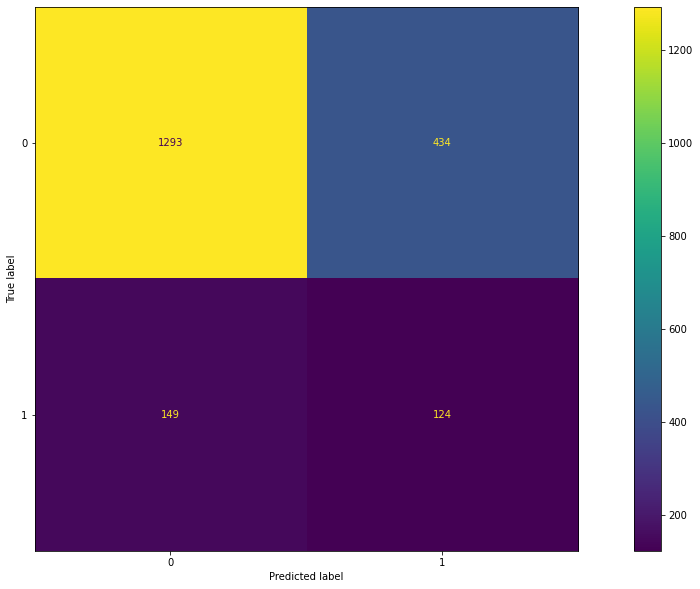

randomforestclassifier

Test roc_auc:  0.5731275094332419

The geometric mean is 0.442

###########################
                     0           1  accuracy    macro avg  weighted avg
precision     0.882289    0.345455     0.838     0.613872      0.809011
recall        0.937464    0.208791     0.838     0.573128      0.838000
f1-score      0.909040    0.260274     0.838     0.584657      0.820483
support    1727.000000  273.000000     0.838  2000.000000   2000.000000
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@



/home/main/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


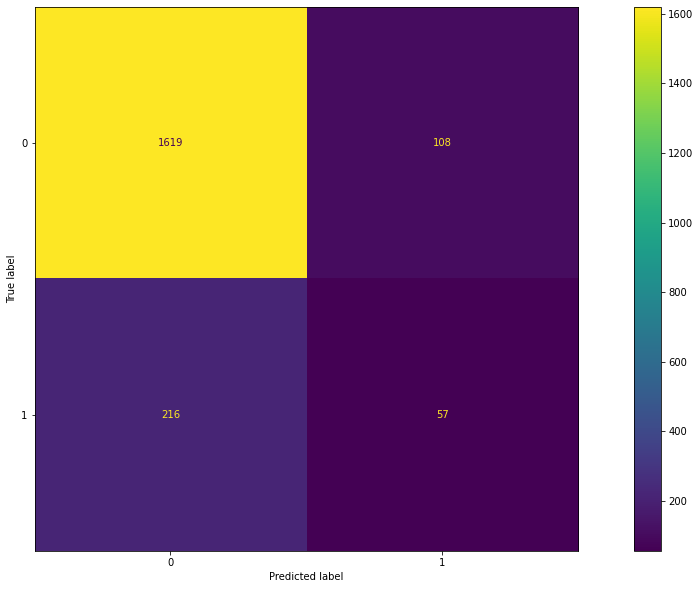

gradientboostingclassifier

Test roc_auc:  0.5889312386127673

The geometric mean is 0.481

###########################
                     0           1  accuracy    macro avg  weighted avg
precision     0.886678    0.356021     0.836     0.621349      0.814243
recall        0.928778    0.249084     0.836     0.588931      0.836000
f1-score      0.907240    0.293103     0.836     0.600172      0.823410
support    1727.000000  273.000000     0.836  2000.000000   2000.000000
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@



/home/main/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


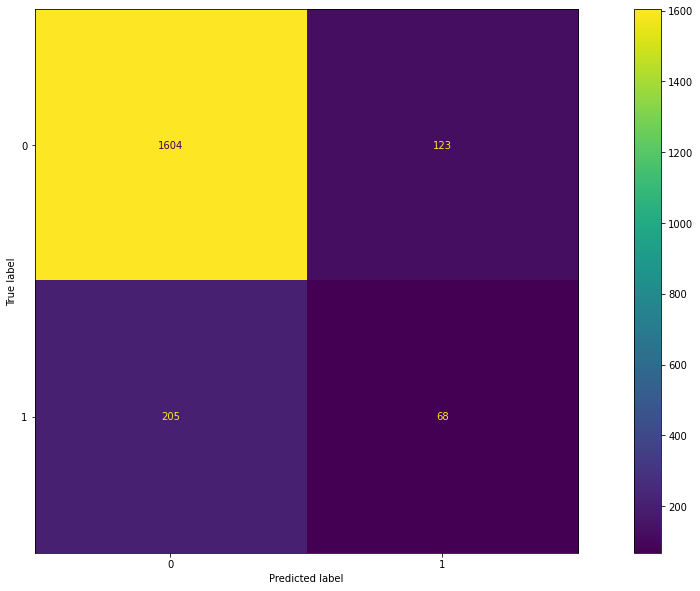

kneighborsclassifier

Test roc_auc:  0.554659777589714

The geometric mean is 0.542

###########################
                     0           1  accuracy    macro avg  weighted avg
precision     0.883068    0.174231     0.641     0.528649      0.786311
recall        0.673422    0.435897     0.641     0.554660      0.641000
f1-score      0.764126    0.248954     0.641     0.506540      0.693805
support    1727.000000  273.000000     0.641  2000.000000   2000.000000
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@



/home/main/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


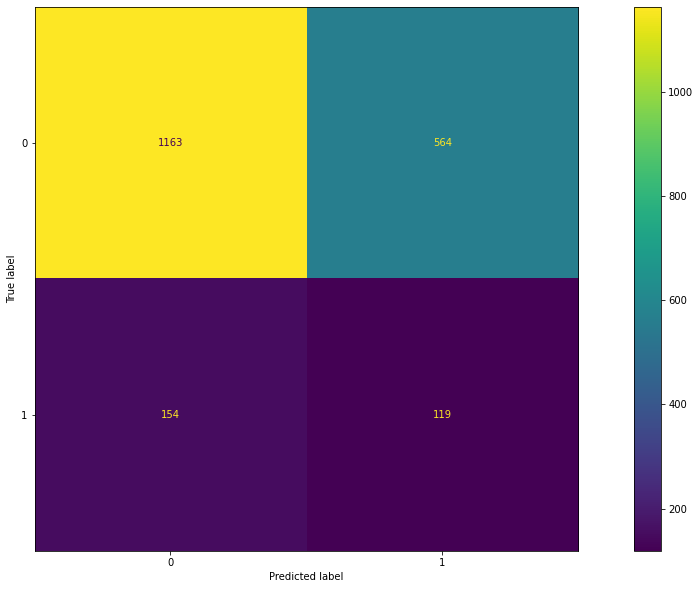

logisticregression

Test roc_auc:  0.5923980478120606

The geometric mean is 0.569

###########################
                     0           1  accuracy    macro avg  weighted avg
precision     0.893297    0.217472    0.7115     0.555384      0.801047
recall        0.756225    0.428571    0.7115     0.592398      0.711500
f1-score      0.819066    0.288533    0.7115     0.553799      0.746648
support    1727.000000  273.000000    0.7115  2000.000000   2000.000000
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@



/home/main/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


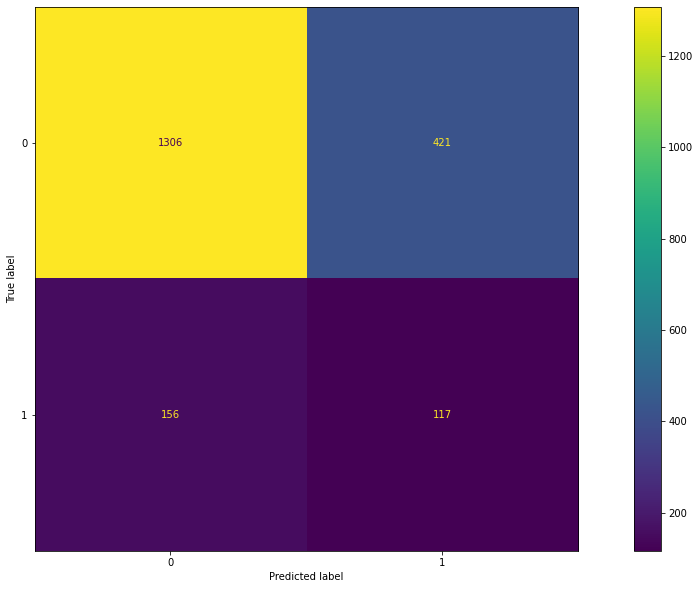

In [24]:
import matplotlib
for model in model_list:
    model_name = f"{model}".lower().split("()")[0]
    model_name = model
    
    print(f"{model}".lower().split("()")[0])
    
    model_pipe = make_pipeline(
            TemporalFeaturesExtraction(variables="earliest_cr_line"), 
            ExtractZipCode(),
            TargetEncoder(True, handle_missing='missing', handle_unknown='missing'),
            ScalerWrapper(),
            MissingValuesImputerWarpper(),
            adasyn,
            ncr,
            model_name
    #         sm,
    #         tl,
    #         smtomek, 
    #     RandomForestClassifier(
    #             n_estimators=100, random_state=39, max_depth=3, n_jobs=4
    #         ),

    )
    
    clf = model_pipe.fit(X_train, y_train) 
    
    X_test_preds = clf.predict(X_test)

    print()
    print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))
    print()
    print(f"The geometric mean is {geometric_mean_score(y_test, X_test_preds):.3f}")
    print()
    print("###########################")
    clf_report_ = pd.DataFrame(classification_report(y_test, X_test_preds, output_dict=True))
    print(clf_report_)
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    print()


    matplotlib.rc('figure', figsize=(20, 10));

    plot_confusion_matrix(clf, X_test, y_test);
    plt.show();

In [25]:
param_grid = {'svc__C': scipy.stats.expon(scale=120),
              'svc__gamma': scipy.stats.expon(scale=.1),
              'svc__kernel': ['rbf','sigmoid', 'precomputed'], 
              'svc__class_weight':['balanced', None]
              
             }

# param_grid = dict(
#     svc__C = stats.randint(10, 15),
# #     svc__gamma = stats.uniform(0, 1),
#     svc__kernel=('rbf'),
#     )



# param_grid = [
#   {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear']},
#   {'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.001, 0.0001], 'svc__kernel': ['rbf']},
#  ]
scores = ["roc_auc", "f1", "balanced_accuracy", "recall", "precision"]

In [26]:
svc = SVC()

In [27]:
model = make_pipeline(
        TemporalFeaturesExtraction(variables="earliest_cr_line"), 
        ExtractZipCode(),
        TargetEncoder(True, handle_missing='missing', handle_unknown='missing'),
        ScalerWrapper(),
        MissingValuesImputerWarpper(),
        adasyn,
        ncr,
        svc
#         sm,
#         tl,
#         smtomek, 
#     RandomForestClassifier(
#             n_estimators=100, random_state=39, max_depth=3, n_jobs=4
#         ),

)
    
    

In [32]:
kfolds = StratifiedKFold(5)

# set up the search
search = RandomizedSearchCV(model,
                            param_grid,
                            scoring=gmean_score,
                            cv=kfolds.split(X_train, y_train),
                            n_iter = 100,
                            random_state=10,
                            n_jobs=4,
                            refit=True)



# main_pipe = make_pipeline(model, search)
# find best hyperparameters
search.fit(X_train, y_train)

/home/main/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
165 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "/home/main/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/main/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/home/main/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 215, in fit
    raise ValueError(
ValueError: Precom

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f43d0a0a900>,
                   estimator=Pipeline(steps=[('temporalfeaturesextraction',
                                              TemporalFeaturesExtraction(variables='earliest_cr_line')),
                                             ('extractzipcode',
                                              ExtractZipCode()),
                                             ('targetencoder',
                                              TargetEncoder(handle_missing='missing',
                                                            handle_unknown='missing',
                                                            verbose=True)),
                                             ('scalerwrapper', ScalerWrapper()...
                   n_iter=100, n_jobs=4,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f43d0d12340>,
                                        'svc__class_weigh

In [33]:
X_test_preds = search.predict(X_test)


print()
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))
print()
print()
print(f"The geometric mean is {geometric_mean_score(y_test, X_test_preds):.3f}")
print()
print("###########################")
clf_report = pd.DataFrame(classification_report(y_test, X_test_preds, output_dict=True))
print(clf_report)


Test roc_auc:  0.4753123734015454


The geometric mean is 0.475

###########################
                     0           1  accuracy    macro avg  weighted avg
precision     0.851586    0.125122      0.48     0.488354      0.752424
recall        0.481760    0.468864      0.48     0.475312      0.480000
f1-score      0.615385    0.197531      0.48     0.406458      0.558348
support    1727.000000  273.000000      0.48  2000.000000   2000.000000


/home/main/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


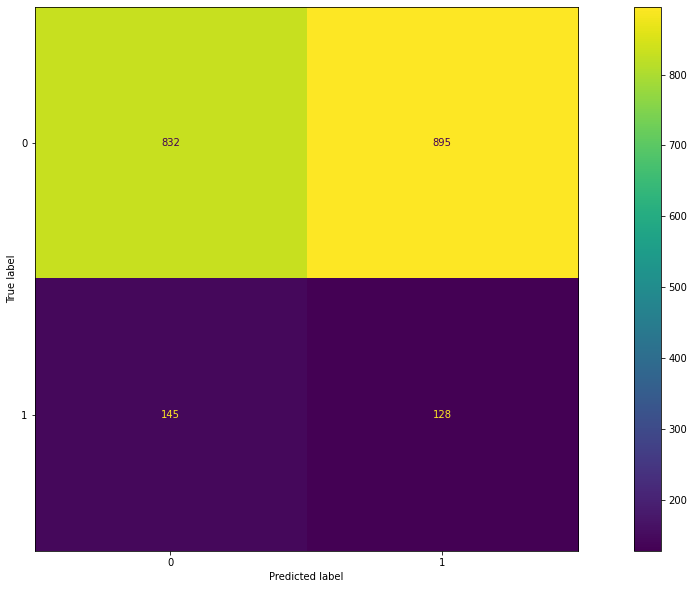

In [34]:

plot_confusion_matrix(search.best_estimator_, X_test, y_test);
plt.show();

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier

from sklearn.ensemble import VotingClassifier
p1 = Pipeline([['clf1', SVC()]])
p2 = Pipeline([['clf2', LogisticRegression()]])
p3 = Pipeline([['clf3', GradientBoostingClassifier()]])
p4 = Pipeline([['clf4', RandomForestClassifier()]])
p5 = Pipeline([['clf5', StackingClassifier(estimators=[
                            ("p1",p1),
                            ("p2",p2),
                            ("p3",p3),
                            ("p4",p4),
                                                    

                            


                                                    ])]])


Test roc_auc:  0.5793770984853788

The geometric mean is 0.476

###########################
                     0           1  accuracy    macro avg  weighted avg
precision     0.884572    0.303571    0.8195     0.594072      0.805265
recall        0.909670    0.249084    0.8195     0.579377      0.819500
f1-score      0.896945    0.273642    0.8195     0.585294      0.811865
support    1727.000000  273.000000    0.8195  2000.000000   2000.000000
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@



/home/main/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


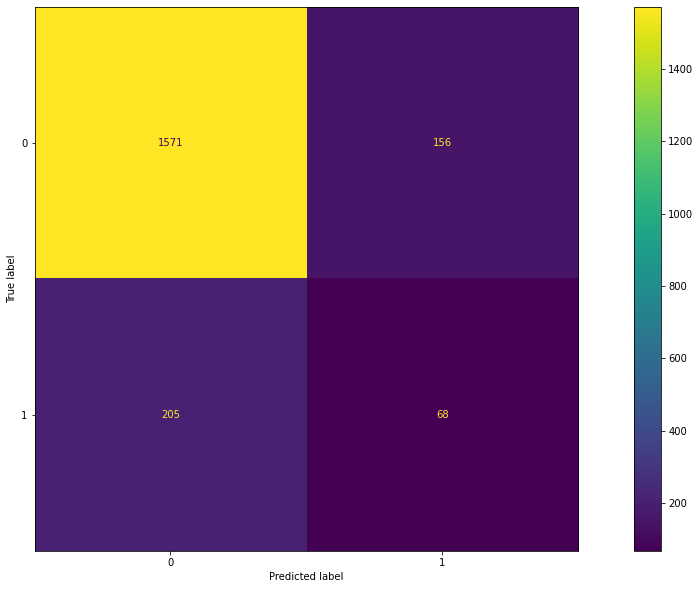

In [54]:
model_pipe = make_pipeline(
        TemporalFeaturesExtraction(variables="earliest_cr_line"), 
        ExtractZipCode(),
        TargetEncoder(True, handle_missing='missing', handle_unknown='missing'),
        ScalerWrapper(),
        MissingValuesImputerWarpper(),
        adasyn,
        ncr,
        p5
#         sm,
#         tl,
#         smtomek, 
#     RandomForestClassifier(
#             n_estimators=100, random_state=39, max_depth=3, n_jobs=4
#         ),

)

clf = model_pipe.fit(X_train, y_train) 

X_test_preds = clf.predict(X_test)

print()
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))
print()
print(f"The geometric mean is {geometric_mean_score(y_test, X_test_preds):.3f}")
print()
print("###########################")
clf_report_ = pd.DataFrame(classification_report(y_test, X_test_preds, output_dict=True))
print(clf_report_)
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
print()


matplotlib.rc('figure', figsize=(20, 10));

plot_confusion_matrix(clf, X_test, y_test);